In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

import ncar_jobqueue
from dask.distributed import Client

### Define CESM case

In [2]:
start_yr=60 #one less than the actual start year since python starts counting at zero
num_years=10 #sim years since last parm change
endyr=start_yr + num_years 
case = 'cesm22cocco.G1850ECOIAF.T62_g17.010'
user = 'kristenk'

### Get ALK and ALK_ALT_CO2

In [3]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):

        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 60 !
doing simulation year 61 !
doing simulation year 62 !
doing simulation year 63 !
doing simulation year 64 !
doing simulation year 65 !
doing simulation year 66 !
doing simulation year 67 !
doing simulation year 68 !
doing simulation year 69 !


In [4]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

In [5]:
variables = ['ALK','ALK_ALT_CO2']

In [6]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [7]:
cesm_ann_ds=cesm_mon_ds.mean(dim='time')

In [8]:
cesm_ann_ds

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (d2) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    dz           (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    KMT          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ALK          (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    ALK_ALT_CO2  (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
Attributes:
    title:             cesm22cocco.G1850ECOIAF.T62_g17.010
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2020-04-22 at 20:30:15.1
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [9]:
alk_diff = cesm_ann_ds.ALK_ALT_CO2 - cesm_ann_ds.ALK

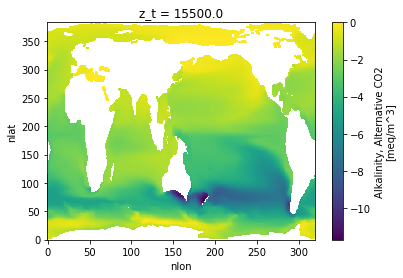

In [10]:
alk_diff.isel(z_t=15).plot()

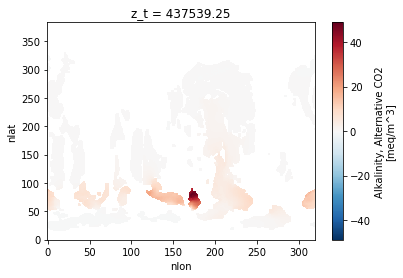

In [11]:
alk_diff.isel(z_t=55).plot()

### CaCO3_fluxes

In [12]:
file = '/glade/scratch/kristenk/archive/' + case + '/ocn/hist/'+case+'.pop.h.ecosys.nyear1.0021.nc'
variables = ['CaCO3_FLUX_IN', 'CaCO3_ALT_CO2_FLUX_IN']

In [13]:
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [14]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [15]:
ds

<xarray.Dataset>
Dimensions:                (d2: 2, nlat: 384, nlon: 320, time: 1, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                    (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
  * z_t_150m               (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
Dimensions without coordinates: d2, nlat, nlon, time
Data variables:
    time_bound             (time, d2) float64 ...
    dz                     (z_t) float32 ...
    TLONG                  (nlat, nlon) float64 ...
    TLAT                   (nlat, nlon) float64 ...
    KMT                    (nlat, nlon) float64 ...
    REGION_MASK            (nlat, nlon) float64 ...
    TAREA                  (nlat, nlon) float64 ...
    CaCO3_FLUX_IN          (time, z_t, nlat, nlon) float32 ...
    CaCO3_ALT_CO2_FLUX_IN  (time, z_t, nlat, nlon) float32 ...
Attributes:
    title:             cesm22cocco.G1850ECOIAF.T62_g17.010
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  year_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2020-04-21 at 19:05:40.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### get the WOA for coords

In [16]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False, chunks={'z_t' : 1})
ds_woa['z_t'] = cesm_ann_ds.z_t

In [17]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
dz=cesm_ann_ds.dz

### Get CaCO3 flux profiles PFZ (sigma 26.2 to 27.1) and SAZ (sigma 26 to 26.8) for Figure 2

In [18]:
SAZ_CaCO3_flux_in = ds.CaCO3_FLUX_IN.where(lats<-30.).where(lats>-50.)

In [19]:
SAZ_CaCO3_flux_in_alt = ds.CaCO3_ALT_CO2_FLUX_IN.where(lats<-30.).where(lats>-50.)

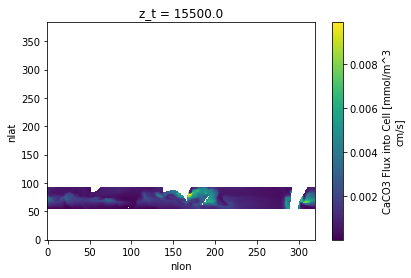

In [20]:
SAZ_CaCO3_flux_in.isel(z_t=15).plot()

In [21]:
CaCO3_FLUX_IN_profile_SAZ_mean =  esmlab.weighted_mean(SAZ_CaCO3_flux_in, weights=area, dim=['nlat', 'nlon']).compute()

In [22]:
CaCO3_FLUX_IN_profile_SAZ_mean = CaCO3_FLUX_IN_profile_SAZ_mean * 0.01 * 86400 * 365 * 0.001 * 100.09
#convert from mmol/m3 cm/s to gCaCO3/m2/yr

In [23]:
CaCO3_FLUX_IN_profile_SAZ_mean_alt =  esmlab.weighted_mean(SAZ_CaCO3_flux_in_alt, weights=area, dim=['nlat', 'nlon']).compute()

In [24]:
CaCO3_FLUX_IN_profile_SAZ_mean_alt = CaCO3_FLUX_IN_profile_SAZ_mean_alt * 0.01 * 86400 * 365 * 0.001 * 100.09
#convert from mmol/m3 cm/s to gCaCO3/m2/yr

In [25]:
CaCO3_FLUX_IN_profile_SAZ_mean =CaCO3_FLUX_IN_profile_SAZ_mean.squeeze()
CaCO3_FLUX_IN_profile_SAZ_mean_alt =CaCO3_FLUX_IN_profile_SAZ_mean_alt.squeeze()

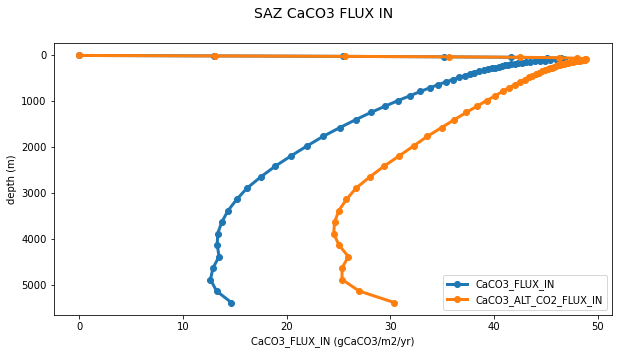

In [26]:
fig = plt.figure(figsize=(10,5))

plt.suptitle('SAZ CaCO3 FLUX IN', fontsize=14)


#COLUMN 1  - ALKs

ax = fig.add_subplot(1,1,1)
ax.plot(CaCO3_FLUX_IN_profile_SAZ_mean.values, depths.values, label='CaCO3_FLUX_IN', linewidth=3,marker='o')
ax.plot(CaCO3_FLUX_IN_profile_SAZ_mean_alt.values, depths.values, label='CaCO3_ALT_CO2_FLUX_IN', linewidth=3,marker='o')
ax.legend()

ax.set(ylabel='depth (m)',xlabel='CaCO3_FLUX_IN (gCaCO3/m2/yr)')
plt.gca().invert_yaxis()


### Check in northern hemisphere

In [27]:
N_CaCO3_flux_in = ds.CaCO3_FLUX_IN.where(lats>30.).where(lats<60.)

In [28]:
N_CaCO3_flux_in_alt = ds.CaCO3_ALT_CO2_FLUX_IN.where(lats>30.).where(lats<60.)

In [29]:
CaCO3_FLUX_IN_profile_N_mean =  esmlab.weighted_mean(N_CaCO3_flux_in, weights=area, dim=['nlat', 'nlon']).compute()

In [30]:
CaCO3_FLUX_IN_profile_N_mean_alt =  esmlab.weighted_mean(N_CaCO3_flux_in_alt, weights=area, dim=['nlat', 'nlon']).compute()

In [31]:
CaCO3_FLUX_IN_profile_N_mean =CaCO3_FLUX_IN_profile_N_mean.squeeze()
CaCO3_FLUX_IN_profile_N_mean_alt =CaCO3_FLUX_IN_profile_N_mean_alt.squeeze()

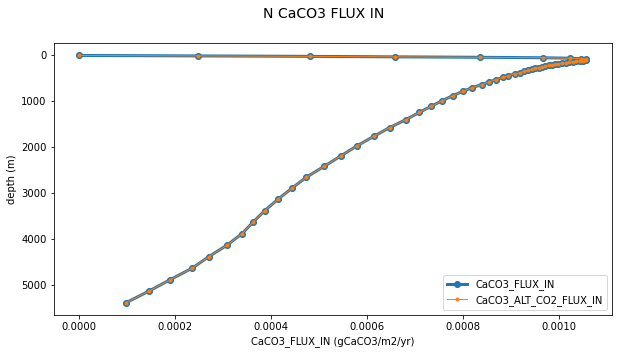

In [32]:
fig = plt.figure(figsize=(10,5))

plt.suptitle('N CaCO3 FLUX IN', fontsize=14)


#COLUMN 1  - ALKs

ax = fig.add_subplot(1,1,1)
ax.plot(CaCO3_FLUX_IN_profile_N_mean.values, depths.values, label='CaCO3_FLUX_IN', linewidth=3,marker='o')
ax.plot(CaCO3_FLUX_IN_profile_N_mean_alt.values, depths.values, label='CaCO3_ALT_CO2_FLUX_IN', linewidth=1,marker='.')
ax.legend()

ax.set(ylabel='depth (m)',xlabel='CaCO3_FLUX_IN (gCaCO3/m2/yr)')
plt.gca().invert_yaxis()
